# ItemKNN Template for Sparsity Evaluation

## Imports 

In [1]:
import os, sys, joblib, json, time, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, KFold
%matplotlib inline 
from caserec.recommenders.rating_prediction.itemknn import ItemKNN
from caserec.utils.process_data import ReadFile
from random import choice
from string import ascii_uppercase
from IPython.display import clear_output
lib_path = './../Sources'
if (lib_path not in sys.path):
    sys.path.append(lib_path) #src directory
from lpsrec.messaging.print_functions import ProgressBar
from lpsrec.messaging.telegrambot import Bot
from lpsrec.utils import partition_dataframe, write_log
import lpsrec.database as db
from caserec.evaluation.rating_prediction import RatingPredictionEvaluation


## Parameters
These parameters are set by a [Papermill](https://github.com/nteract/papermill) runner script

In [2]:
dataset_tag = 'ML100k'
model_tag = 'ItemKNN'
rank_length = 30
random_state = 31415
evaluation_metrics = ['PREC', 'RECALL', 'NDCG', 'MRR', 'MAP']
bot_alive = False
partition = 2
nodes = 10
n_folds = 5

In [3]:
analysis_tag = '_'.join([str(x) for x in [rank_length, nodes, partition]])
n_folds = None if n_folds == 1 else n_folds
style_dict = json.load(open('./style_dict.json', 'r'))
dataset_output_folder = os.path.join('.', 'Outputs', dataset_tag)
variables_output_folder = os.path.join(dataset_output_folder, model_tag, 'Variables', analysis_tag)
figures_output_folder = os.path.join(dataset_output_folder, model_tag, 'Figures', analysis_tag)
progbar = ProgressBar(bar_length=20, bar_fill='#', elapsed_time=True)
if not os.path.exists(variables_output_folder):    
    os.makedirs(variables_output_folder)    
if not os.path.exists(figures_output_folder):        
    os.makedirs(figures_output_folder)

In [4]:
plt.rc('font', **style_dict['font'])
# plt.rc('axes.titlesize', fontsize=20)
plt.rc('xtick', labelsize=style_dict['tick']['fontsize']) 
plt.rc('ytick', labelsize=style_dict['tick']['fontsize']) 
plt.rcParams.update({'figure.max_open_warning': 5})

In [5]:
bot = Bot(user_credentials='./JFGS.json')
bot.send_message(text="{}\nHello, John. Initiating sparsity analysis for the {} dataset on the {} model [{}/{}]".format('-'*20, dataset_tag, model_tag, partition, nodes)) if bot_alive else ''

''

## Connecting to Database

In [6]:
username = 'postgres'
password = 'admin'
dbname = 'RecSys'
hostname = 'localhost:5432'
conn = db.get_database_connection(username, password, hostname, dbname)

## Loading Dataset

In [7]:
%%time
df_ratings = db.get_dataset_from_sparsity(data_path=None, conn=conn, dataset_tag=dataset_tag) 
df_ratings[['feedback_value']] = df_ratings[['feedback_value']].apply(pd.to_numeric)
df_ratings.drop(['user', 'item', 'timestamp'], axis=1, inplace=True)
df_ratings.columns = ['feedback_value', 'user', 'item']

Wall time: 1.29 s


In [8]:
print (df_ratings.shape)
df_ratings.head()

(100000, 3)


,feedback_value,user,item
0,5,1,1
1,3,1,2
2,4,1,3
3,3,1,4
4,3,1,5


In [9]:
df_train, df_test = train_test_split(df_ratings, test_size=0.3, random_state=random_state)
print ("Train size: {} \nTest size: {}".format(df_train.shape[0], df_test.shape[0]))

Train size: 70000 
Test size: 30000


## Training Model

In [11]:
predictions_output_filepath = './predictions_output_' + ''.join(choice(ascii_uppercase) for i in range(12)) + '.dat'
model = ItemKNN(train_file=df_train, test_file=df_test, k_neighbors=30, output_file = predictions_output_filepath)

In [12]:
%%time
model.compute(verbose=True)

[Case Recommender: Rating Prediction > ItemKNN Algorithm]

train data:: 943 users and 1631 items (70000 interactions) | sparsity:: 95.45%
test data:: 943 users and 1490 items (30000 interactions) | sparsity:: 97.86%

training_time:: 3.059845 sec
prediction_time:: 4.418180 sec
Eval:: MAE: 0.799845 RMSE: 1.036748 
Wall time: 14.6 s


## Evaluating Model

In [13]:
# Creating evaluator with item-recommendation parameters
evaluator = RatingPredictionEvaluation(sep = '\t', 
                                       n_rank = np.arange(1,rank_length+1, 1), 
                                       as_rank = True,
                                       metrics = ['PREC', 'RECALL'])

In [14]:
reader = ReadFile(input_file=predictions_output_filepath)
predictions = reader.read()
eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)   
for evaluation in model.evaluation_results.keys():
    eval_results[evaluation] = model.evaluation_results[evaluation]
os.remove(predictions_output_filepath)

Eval:: PREC@1: 0.766702 PREC@2: 0.750795 PREC@3: 0.735949 PREC@4: 0.716596 PREC@5: 0.695864 PREC@6: 0.679215 PREC@7: 0.657931 PREC@8: 0.638123 PREC@9: 0.620007 PREC@10: 0.602121 PREC@11: 0.587776 PREC@12: 0.571492 PREC@13: 0.557631 PREC@14: 0.544008 PREC@15: 0.530223 PREC@16: 0.517564 PREC@17: 0.505521 PREC@18: 0.493284 PREC@19: 0.482614 PREC@20: 0.472853 PREC@21: 0.462657 PREC@22: 0.453581 PREC@23: 0.443635 PREC@24: 0.434076 PREC@25: 0.424942 PREC@26: 0.416918 PREC@27: 0.408507 PREC@28: 0.401265 PREC@29: 0.393608 PREC@30: 0.386285 RECALL@1: 0.093902 RECALL@2: 0.173493 RECALL@3: 0.246768 RECALL@4: 0.309619 RECALL@5: 0.362126 RECALL@6: 0.41057 RECALL@7: 0.44748 RECALL@8: 0.480074 RECALL@9: 0.50725 RECALL@10: 0.531456 RECALL@11: 0.555267 RECALL@12: 0.574708 RECALL@13: 0.593235 RECALL@14: 0.609718 RECALL@15: 0.62425 RECALL@16: 0.637123 RECALL@17: 0.649237 RECALL@18: 0.660193 RECALL@19: 0.670963 RECALL@20: 0.681393 RECALL@21: 0.690151 RECALL@22: 0.699017 RECALL@23: 0.706021 RECALL@24: 0.71

In [15]:
joblib.dump(eval_results, os.path.join(variables_output_folder, 'evaluation_results.joblib'))

['.\\Outputs\\ML100k\\ItemKNN\\Variables\\30_10_2\\evaluation_results.joblib']

### Plotting Evaluations

''

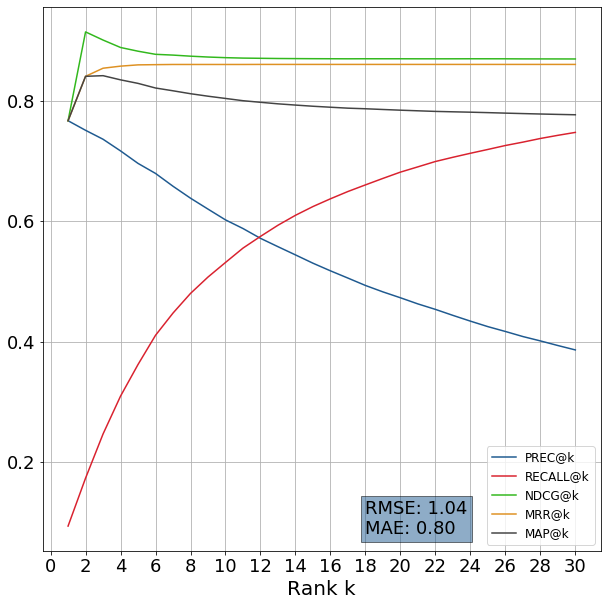

In [17]:
evaluation_results = joblib.load(os.path.join(variables_output_folder, 'evaluation_results.joblib'))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
arr_k = np.arange(1, rank_length+1, 1)
for evaluation_name in [m + '@' for m in evaluation_metrics]:
    ax.plot(arr_k, [evaluation_results[evaluation_name + str(x)] for x in arr_k], label=evaluation_name + 'k', color=style_dict['evaluations'][evaluation_name + 'k'])
ax.text(s='RMSE: {:.02f}\nMAE: {:.02f}'.format(evaluation_results['RMSE'], evaluation_results['MAE']), 
        y=0.08, x=18, 
        fontsize=style_dict['label']['fontsize']-2, 
        color='black', bbox=dict(facecolor='#1F5A90', alpha=0.5))
ax.set_xticks(np.arange(0, np.max(arr_k)+1, 2), minor=False)
ax.set_xlabel('Rank k', fontsize = style_dict['label']['fontsize'])
ax.tick_params(axis='both', which='major', labelsize=style_dict['tick']['fontsize'])
ax.legend()
ax.grid(True)

filepath = os.path.join(figures_output_folder, 'item_rec_metrics.png')
plt.savefig(filepath, bbox_inches = 'tight')
bot.send_message(filePath=filepath) if bot_alive else ''

## Evaluating on Sparsity Cenarios

In [18]:
dataset_info = pd.read_sql(con=conn , sql="select * from datasets.dataset where version='{}'".format(dataset_tag))
df_sparsity_cenario = pd.read_sql(con=conn , sql="select * from sparsity.cenario")
sql_str = "select id_user, id_item from sparsity.get_dataset_from_sparsity('{}', 1.0, 1.0)".format(dataset_tag)
df_whole = pd.read_sql(con=conn, sql=sql_str)
print ("Dataset {} (id_dataset = {}) with {} registers".format(dataset_info['name'][0], dataset_info['id_dataset'][0], df_whole.shape[0]))
print ("Number of sparsity cenarios: ", df_sparsity_cenario.shape[0])
df_sparsity_cenario.head()

Dataset MovieLens 100k (id_dataset = 1) with 100000 registers
Number of sparsity cenarios:  1296


,id_sparsity_cenario,uss,iss
0,10759,0.3,0.30
1,10760,0.3,0.32
2,10761,0.3,0.34
3,10762,0.3,0.36
4,10763,0.3,0.38


In [19]:
sql_str = """select * from sparsity.get_dataset_uss('{}')""".format(dataset_tag)
df_users_uss = pd.read_sql(con=conn, sql=sql_str)
df_users_uss.sort_values(['uss'], ascending=False).head()

,id_user_dataset,uss,n_feedback,max_feedback,id_user
363,364,0.972863,20,737,364
823,824,0.972863,20,737,824
811,812,0.972863,20,737,812
241,242,0.972863,20,737,242
808,809,0.972863,20,737,809


In [20]:
sql_str = """select * from sparsity.get_dataset_iss('{}')""".format(dataset_tag)
df_items_iss = pd.read_sql(con=conn, sql=sql_str)
df_items_iss.sort_values(['iss'], ascending=False).head()

,id_item_dataset,iss,n_feedback,max_feedback,id_item
1681,1682,0.998285,1,583,1682
676,677,0.998285,1,583,677
710,711,0.998285,1,583,711
1586,1587,0.998285,1,583,1587
1585,1586,0.998285,1,583,1586


In [21]:
uss_limits = df_sparsity_cenario['uss'].unique()
iss_limits = df_sparsity_cenario['iss'].unique()

In [22]:
df_ratings.head(3)

,feedback_value,user,item
0,5,1,1
1,3,1,2
2,4,1,3


In [23]:
df_overall_sparsity = pd.read_csv(os.path.join('.', 'Outputs', dataset_tag, 'OS', 'Variables', 'df_overall_sparsity.tsv'), sep = '\t', header = 0)
if partition is not None:
    df_overall_sparsity = partition_dataframe(df=df_overall_sparsity, nodes=nodes, sort_by='os', ascending=False)[partition-1].reset_index(drop = True)
print ("Input sparsity cenario dataframe shape: ", df_overall_sparsity.shape)
df_overall_sparsity.head()

Input sparsity cenario dataframe shape:  (130, 5)


,uss_limit,iss_limit,os,num_users,num_items
0,0.98,1.00,0.936953,943.0,1682.0
1,0.88,1.00,0.881747,389.0,1682.0
2,0.92,0.98,0.850611,503.0,1099.0
3,0.98,0.88,0.827987,943.0,465.0
4,0.96,0.90,0.811508,744.0,546.0


In [24]:
def get_evaluation_results(model, df_train, df_test, rank_length, uss_limit = None, iss_limit = None):
    predictions_output_filepath = './predictions_output_' + ''.join(choice(ascii_uppercase) for i in range(12)) + '.dat'
    
    model = ItemKNN(train_file=df_train, test_file=df_test, k_neighbors=30, output_file = predictions_output_filepath)
    model.compute(verbose=False)    
    
    predictions = ReadFile(input_file=predictions_output_filepath).read()
    eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)   
    for evaluation in model.evaluation_results.keys():
        eval_results[evaluation] = model.evaluation_results[evaluation]
    os.remove(predictions_output_filepath)
    
    evaluation_results = pd.DataFrame.from_dict(data=eval_results, orient='index').T
    if (uss_limit is not None and iss_limit is not None):
        evaluation_results['iss'] = [iss_limit]
        evaluation_results['uss'] = [uss_limit]
    return evaluation_results

In [25]:
%%time
write_log(filepath=os.path.join(variables_output_folder, 'log.txt'), 
          mode="w+", 
          text='[{}]\tUSS \tISS \tIndex\tPerc\tFolder\n'.format(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())))    

arr_k = np.arange(1, rank_length+1, 1)
arr_df_eval_metadata = np.repeat(None, 1) if n_folds == None else np.repeat(None, n_folds)
first_value = [True] if n_folds == None else np.repeat(True, n_folds)
kf = None if n_folds == None else KFold(n_splits=n_folds, random_state=random_state) 
# for uss_index, uss_limit in enumerate(uss_limits):
#     for iss_limit in iss_limits:   
for index, cenario in df_overall_sparsity.iterrows():
    clear_output()
    progbar.update_progress(index/float(df_overall_sparsity.shape[0]))   

    start_time = time.time()
    df_ratings = db.get_dataset_from_sparsity(conn=conn, dataset_tag=dataset_tag,                                               
                                              iss=cenario['iss_limit'], 
                                              uss=cenario['uss_limit'])

    df_ratings.drop(['user', 'item', 'timestamp'], axis=1, inplace=True)    
    df_ratings[['feedback_value']] = df_ratings[['feedback_value']].apply(pd.to_numeric)
    df_ratings.columns = ['feedback_value', 'user', 'item']    
    
    if n_folds == None:
        df_train, df_test = train_test_split(df_ratings, test_size=0.3, random_state=random_state)
        evaluation_results = get_evaluation_results(model, df_train, df_test, rank_length, cenario['uss_limit'], cenario['iss_limit'])            
        elapsed_time = time.time() - start_time
        evaluation_results['elapsed_time'] = [elapsed_time]
        
        if (first_value[0]):            
            first_value[0] = False
            arr_df_eval_metadata[0] = evaluation_results.copy()    
        else:
            arr_df_eval_metadata[0] = arr_df_eval_metadata[0].append(evaluation_results)    
        write_log(filepath=os.path.join(variables_output_folder, 'log.txt'), 
                  text='[{}]\t{:.02f}\t{:.02f}\t{}/{}\t{:.02f}%\t{}/{}\n'.format(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()), 
                                                                                 cenario['uss_limit'], 
                                                                                 cenario['iss_limit'], 
                                                                                 index+1, 
                                                                                 df_overall_sparsity.shape[0], 
                                                                                 100*(index/float(df_overall_sparsity.shape[0])), 
                                                                                 1, 
                                                                                 1)
                 )
    else:
        
        index_folder = 1
        # Tentar fazer um shuffle e voltar com essa estrategia
#         for train_index, test_index in kf.split(df_ratings):              
#             df_train, df_test = df_ratings.iloc[train_index], df_ratings.iloc[test_index]            

        for index_folder in np.arange(1, n_folds+1, 1):
            df_train, df_test = train_test_split(df_ratings, test_size=0.3, random_state=random_state+10*index_folder-1)
            
            print ("Processing folder {}/{}...\n".format(index_folder, n_folds))
            evaluation_results = get_evaluation_results(model, df_train, df_test, rank_length, cenario['uss_limit'], cenario['iss_limit'])            
            elapsed_time = time.time() - start_time
            evaluation_results['elapsed_time'] = [elapsed_time]

            if (first_value[index_folder-1]):            
                first_value[index_folder-1] = False
    #             df_eval_metadata = evaluation_results.copy()
                arr_df_eval_metadata[index_folder-1] = evaluation_results.copy()
            else:
                arr_df_eval_metadata[index_folder-1] = arr_df_eval_metadata[index_folder-1].append(evaluation_results)    
            write_log(filepath=os.path.join(variables_output_folder, 'log.txt'), 
                      text='[{}]\t{:.02f}\t{:.02f}\t{}/{}\t{:.02f}%\t{}/{}\n'.format(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime()), 
                                                                                     cenario['uss_limit'], 
                                                                                     cenario['iss_limit'], 
                                                                                     index+1, 
                                                                                     df_overall_sparsity.shape[0], 
                                                                                     100*(index/float(df_overall_sparsity.shape[0])), 
                                                                                     index_folder, 
                                                                                     n_folds)
                     )
            index_folder += 1

for index, df_eval_metadata in enumerate(arr_df_eval_metadata):
    folder_name = '1_1' if n_folds == None else str(n_folds) + '_' + str(index+1)
    df_eval_metadata.reset_index(drop = True, inplace=True)
    df_eval_metadata.to_csv(os.path.join(variables_output_folder, 'df_eval_metadata_fold{}.tsv'.format(folder_name)), sep = '\t', header = True, index = False)
text = "Finished creating sparsity datasets [partition = {}] for\t{} in\t{}".format(partition, dataset_tag, progbar.get_elapsed_time())
bot.send_message(text=text) if bot_alive else ''       
write_log(filepath=os.path.join(variables_output_folder, 'log.txt'), text=text)
print (text)

[0:42:07][####################] 99.23% Processing folder 1/5...

Eval:: MAE: 0.828557 RMSE: 1.049811 
Eval:: PREC@1: 0.777778 PREC@2: 0.722222 PREC@3: 0.703704 PREC@4: 0.694444 PREC@5: 0.6 PREC@6: 0.537037 PREC@7: 0.492063 PREC@8: 0.458333 PREC@9: 0.407407 PREC@10: 0.366667 PREC@11: 0.333333 PREC@12: 0.305556 PREC@13: 0.282051 PREC@14: 0.261905 PREC@15: 0.244444 PREC@16: 0.229167 PREC@17: 0.215686 PREC@18: 0.203704 PREC@19: 0.192982 PREC@20: 0.183333 PREC@21: 0.174603 PREC@22: 0.166667 PREC@23: 0.15942 PREC@24: 0.152778 PREC@25: 0.146667 PREC@26: 0.141026 PREC@27: 0.135802 PREC@28: 0.130952 PREC@29: 0.126437 PREC@30: 0.122222 RECALL@1: 0.172354 RECALL@2: 0.316931 RECALL@3: 0.452249 RECALL@4: 0.587566 RECALL@5: 0.619974 RECALL@6: 0.649735 RECALL@7: 0.679497 RECALL@8: 0.709259 RECALL@9: 0.709259 RECALL@10: 0.709259 RECALL@11: 0.709259 RECALL@12: 0.709259 RECALL@13: 0.709259 RECALL@14: 0.709259 RECALL@15: 0.709259 RECALL@16: 0.709259 RECALL@17: 0.709259 RECALL@18: 0.709259 RECALL@19: 0.70

In [ ]:
print ("Variables saved @ ", variables_output_folder)
bot.send_message(text="End of analysis for the {} dataset\n{}".format(dataset_tag, '-'*20)) if bot_alive else ''

_________________

In [ ]:
# df_eval_metadata = pd.read_csv(os.path.join(variables_output_folder, 'df_eval_metadata.tsv'), sep = '\t', header = 0)

In [ ]:
# df_eval_metadata.head()

In [ ]:
# uss_limits = np.sort(np.array(df_eval_metadata['uss'].unique()))
# iss_limits = np.sort(np.array(df_eval_metadata['iss'].unique()))
# rank_lengths = np.arange(1, rank_length+1, 1) # Setting extra rank analysis

# for rank in rank_lengths:
#     arr_rank_metrics = [m + '@' + str(rank) for m in evaluation_metrics]
#     for column in arr_rank_metrics:
#         arr_metric = np.zeros([len(uss_limits), len(iss_limits)])
#         for uss_index, uss_limit in enumerate(uss_limits):
#             for iss_index, iss_limit in enumerate(iss_limits):            
#                 arr_metric[uss_index, iss_index] = df_eval_metadata[(df_eval_metadata['uss'] == uss_limit) & (df_eval_metadata['iss'] == iss_limit)][column].reset_index(drop = True)[0]

#         joblib.dump(arr_metric, os.path.join(variables_output_folder, 'arr_' + column.lower() + '_' + model_tag + '.joblib'))        

## Plotting Results from Sparsity Cenarios

In [ ]:
# cmapping = "jet"
# tick_step = 5
# figs = dict()
# for metric in evaluation_metrics:
#     figs[metric+'@'] = list()

# for rank in rank_lengths:
#     arr_rank_metrics = [m + '@' + str(rank) for m in evaluation_metrics]
#     for column in arr_rank_metrics:
#         arr_prec = joblib.load(os.path.join(variables_output_folder, 'arr_' + column.lower() + '_' + model_tag + '.joblib'))        

#         fig, ax = plt.subplots(figsize=(style_dict['figure']['width'],style_dict['figure']['height']))    
#         cax = plt.imshow(arr_prec, cmap=cmapping)
#         plt.gca().invert_yaxis()
#         cbar = plt.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,10)], shrink = 0.83)

#         ax.set_xticklabels(uss_limits[0:len(uss_limits):tick_step])
#         ax.set_yticklabels(iss_limits[0:len(uss_limits):tick_step])
#         ax.set_xticks(np.arange(0, len(uss_limits), tick_step))    
#         ax.set_yticks(np.arange(0, len(iss_limits), tick_step))    
#         ax.set_xlabel('Last User Specific Sparsity', fontsize = style_dict['label']['fontsize'])
#         ax.set_ylabel('Last Item Specific Sparsity', fontsize = style_dict['label']['fontsize'])    
#         ax.tick_params(axis='both', which='major', labelsize=style_dict['tick']['fontsize'])
#         cbar.set_label(column.title(), labelpad=-50,  y=1.08, rotation=0, fontsize = style_dict['label']['fontsize'])
#         cbar.ax.tick_params(labelsize = style_dict['tick']['fontsize'])
#         plt.clim(0, 1)
#         plt.xticks(rotation = 'vertical')

#         filename = '2d-' + column + '.png'       
#         fig.savefig(os.path.join(figures_output_folder, filename), bbox_inches = 'tight')
        
#         fig.set_animated(True)
#         figs[re.split("\d", column)[0]].append(fig)        
#         if rank == rank_length: # Send only the target-analysis
#             bot.send_message(filePath=os.path.join(figures_output_folder, filename)) if bot_alive else ''

In [ ]:


# for metric in evaluation_metrics:    
#     filepaths = [os.path.join(figures_output_folder, '2d-' + column + '.png' ) for column in [metric + '@' + str(rank) for rank in rank_lengths]]
#     output_filepath = os.path.join(figures_output_folder, '2d-' + metric + '@k' + '.gif' )
#     create_gif(filepaths, output_filepath, duration=0.2)

In [ ]:
# from IPython import display
# # display.HTML('<img src="{}">'.format(output_filepath))

In [ ]:
# show_metric = lambda metric, k: figs[metric + '@'][int(k)-1]
# interact(show_metric, k=widgets.IntSlider(min=1, max=rank_length, step=1, value=10), figs=figs, metric=evaluation_metrics)

__________